In [1]:
import pickle
import json
import numpy as np
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from wordcloud import WordCloud, STOPWORDS

In [2]:
#data
path_layer1 ='/srv/datasets2/recipe1m+/utfood_3.10/layer1.json'
with open(path_layer1, "r") as f:
    layer1 = json.load(f)
with open('/srv/datasets2/recipe1m+/food.com_data_rescaled/nutr/food.com_nutr_g_per_recipe.json') as f:
    nutr_per_recipes = json.load(f)
with open('/home/parinayok/nutr1m/data_crawl/food.com_annotated_nutr_per_recipe_old.json') as f:
    nutr_per_recipes_total = json.load(f)
with open('/srv/datasets2/recipe1m+/food.com_data_rescaled/nutr/simplified_food_ids_per_recipes.json') as f:
    food_ids_per_recipes = json.load(f)
with open('/srv/datasets2/recipe1m+/food.com_data_rescaled/nutr/simplified_weighted_food_ids_per_recipes.json') as f:
    weighted_food_ids_per_recipes = json.load(f)
with open('ingredient_meds.json') as f:
    ingredient_meds = json.load(f)

In [3]:
#inference results
path = 'results_50_ret/ht/base.json'
with open(path) as f:
    im2recipe_dict = json.load(f)
with open('results_50_ret/tfood/base_wo_clip/_recipe_only.json') as f:
    im2recipe_dict_tfood = json.load(f)
with open('results_50_ret/vlp/org_finetuned_recipe1m+/_recipe_only.json') as f:
    im2recipe_dict_vlp = json.load(f)
with open('results_recipe2recipe/ht/base.json') as f:
    recipe2recipe_dict = json.load(f)
with open('results_recipe2recipe/tfood/base_wo_clip/_recipe_only.json') as f:
    recipe2recipe_dict_tfood = json.load(f)
with open('results_recipe2recipe/vlp/org_finetuned_recipe1m+/_recipe_only.json') as f:
    recipe2recipe_dict_vlp = json.load(f)
with open('im2recipe_dict_mase.json') as f:
    im2recipe_dict_mase = json.load(f)
with open('im2recipe_dict_iou.json') as f:
    im2recipe_dict_iou = json.load(f)
with open('im2recipe_dict_wiou_fixed.json') as f:
    im2recipe_dict_wiou = json.load(f)
with open('im2recipe_dict_norm_wiou.json') as f:
    im2recipe_dict_norm_wiou = json.load(f)
with open('random_queries.json') as f:
    random_queries = json.load(f)
with open('queries_all.json') as f:
    queries_all = json.load(f)

In [32]:
class Radar(object):
    def __init__(self, fig, labels, max_values, rect=None, num_ticks = 5):
        if rect is None:
            rect = [0.05, 0.05, 0.95, 0.95]

        self.n = len(labels)
        self.labels = labels
        self.max_values = max_values
        self.num_ticks = num_ticks
        self.angles = np.arange(90, 90+360, 360.0/self.n)
        self.axes = [fig.add_axes(rect, projection="polar", label="axes%d" % i)
                         for i in range(self.n)]

        self.ax = self.axes[0]
        self.ax.set_thetagrids(self.angles, labels=labels, fontsize='x-large')

        for ax in self.axes[1:]:
            ax.patch.set_visible(False)
            ax.grid("off")
            ax.xaxis.set_visible(False)

        for ax, angle, max_value in zip(self.axes, self.angles, max_values):
            label = np.linspace(0,max_value,num_ticks)
            ax.set_rgrids(range(num_ticks), angle=angle, labels=label, fontsize='x-large')
            ax.spines["polar"].set_visible(False)
            ax.set_ylim(0, num_ticks)

    def plot(self, values, *args, **kw):
        values = [value/max_value*self.num_ticks for value, max_value in zip(values,self.max_values)]
        angle = np.deg2rad(np.r_[self.angles, self.angles[0]])
        values = np.r_[values, values[0]]
        self.ax.plot(angle, values, *args, **kw)
        self.ax.fill(angle, values, alpha=0.15, *args, **kw)

In [33]:
def get_img(query):
    img_dir = '/srv/datasets2/recipe1m+/raw_htmls'
    query_splits = query.split('_')
    img_path = f'{img_dir}/{query_splits[0]}/recipe-{query_splits[1]}.jpg'
    img = Image.open(img_path)
    return img

In [42]:
max_values = [500,50,50,50]
labels = ['energy (kcal)','fat (g)','carb (g)','protein (g)']
stopwords = set(STOPWORDS)
stopwords.update(["can", "cans", "liter", "liters", "l.", "piece", "pieces", "ml", "milliliter", "milliliters", "millilitre", "millilitres", "inch", "inches", "pound", "pounds", "lb", "lbs", "pinch","cup", "cups", "teaspoon", "teaspoons", "tsp", "tsps", "tablespoon", "tablespoons", "tbsp", "tbsps", "gram", "grams", "g", "ounce", "ounces", "oz", "well", "add", "time", "minutes", "minute", "min", "mins", "second", "seconds", "sec", "secs", "hour", "hours", "hr", "hrs", "til", "till", "ones", "quarter", "quarters", "ingredient", "ingredients", "temperature", "temp", "F", "C", "serve", "serves", "served", "serving", "servings", "will", "don't", "make sure", "may", "often", "meanwhile", "put", ])

def show_recipe_result(recipe_id):
    title = layer1[recipe_id]['title']
    print(f'Title: {title}')
    print('Ingredients:')
    ingredients = layer1[recipe_id]['ingredients']
    ingredients_text = '\n'.join(ingredients)
    print(f'{ingredients_text}')
    print('Instructions:')
    instructions = layer1[recipe_id]['instructions']
    for inst_i, instruction in enumerate(instructions):
        print(f'{inst_i+1}. {instruction}')

    fig = plt.figure(figsize=(12,9))
    # plt.xticks([])
    # plt.yticks([])
    (left_fig, right_fig) = fig.subfigures(1,2)
    left_axs = left_fig.subplots(2,1)

    # plot image
    img = get_img(recipe_id)
    left_axs[0].imshow(img)
    left_axs[0].axis('off')
    left_axs[0].get_xaxis().set_visible(False)
    left_axs[0].get_yaxis().set_visible(False)
    # left_axs[0].margins(0)
    # left_axs[0].grid('off')
    # plt.axis("off")
    # plt.yticks([])
    # plt.title(recipe_id)
    # plt.show()
    # plt.close()

    # plot radar chart
    nutr = nutr_per_recipes[recipe_id]
    # fig = plt.figure(figsize=(6, 6))
    radar = Radar(right_fig, labels, max_values)
    # print([nutr['energy'],nutr['fat'],nutr['carb'],nutr['protein']])
    radar.plot([nutr['energy'],nutr['fat'],nutr['carb'],nutr['protein']],  "-", lw=2, color="b")
    # plt.show()
    # plt.close()

    #word cloud
    all_text = '\n'.join([ingredients_text, *instructions])
    wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(all_text)

    # Display the generated image:
    left_axs[1].imshow(wordcloud, interpolation='bilinear')
    left_axs[1].axis('off')
    left_axs[1].get_xaxis().set_visible(False)
    left_axs[1].get_yaxis().set_visible(False)
    fig.subplots_adjust(wspace=0, hspace=0)
    # plt.autoscale(tight=True)
    # plt.tight_layout()
    plt.show()
    plt.close()

def show_recipe_result_2(recipe_id):
    ingredients = layer1[recipe_id]['ingredients']
    ingredients_text = '\n'.join(ingredients)
    instructions = layer1[recipe_id]['instructions']

    fig = plt.figure(figsize=(9,12))
    # plt.xticks([])
    # plt.yticks([])
    ((top_left, top_right),(bottom_left, bottom_right)) = fig.subfigures(2,2)
    # left_axs = left_fig.subplots(2,1)
    top_left_ax = top_left.add_axes([0.05,0.05,0.95,0.95])

    # plot image
    img = get_img(recipe_id)
    top_left_ax.imshow(img)
    top_left_ax.axis('off')
    top_left_ax.get_xaxis().set_visible(False)
    top_left_ax.get_yaxis().set_visible(False)
    # left_axs[0].margins(0)
    # left_axs[0].grid('off')
    # plt.axis("off")
    # plt.yticks([])
    # plt.title(recipe_id)
    # plt.show()
    # plt.close()

    # plot radar chart
    nutr = nutr_per_recipes[recipe_id]
    # fig = plt.figure(figsize=(6, 6))
    radar = Radar(bottom_right, labels, max_values,num_ticks = 3)
    # print([nutr['energy'],nutr['fat'],nutr['carb'],nutr['protein']])
    radar.plot([nutr['energy'],nutr['fat'],nutr['carb'],nutr['protein']],  "-", lw=2, color="b")
    # plt.show()
    # plt.close()

    #word cloud
    all_text = '\n'.join([ingredients_text, *instructions])
    wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(all_text)

    # Display the generated image:
    bottom_left_ax = bottom_left.add_axes([0.05,0.05,0.95,0.95])
    bottom_left_ax.imshow(wordcloud)
    bottom_left_ax.axis('off')
    bottom_left_ax.get_xaxis().set_visible(False)
    bottom_left_ax.get_yaxis().set_visible(False)
    fig.subplots_adjust(wspace=0, hspace=0)
    # plt.autoscale(tight=True)
    # plt.tight_layout()
    plt.show()
    plt.close()

def show_recipe_result_3(recipe_id):
    title = layer1[recipe_id]['title']
    print(f'Title: {title}')
    print('Ingredients:')
    ingredients = layer1[recipe_id]['ingredients']
    ingredients_text = '\n'.join(ingredients)
    print(f'{ingredients_text}')
    print('Instructions:')
    instructions = layer1[recipe_id]['instructions']
    for inst_i, instruction in enumerate(instructions):
        print(f'{inst_i+1}. {instruction}')

    fig = plt.figure(figsize=(12,9))
    # plt.xticks([])
    # plt.yticks([])
    (left_fig, right_fig) = fig.subfigures(1,2)
    left_axs = left_fig.subplots(2,1)

    # plot image
    img = get_img(recipe_id)
    left_axs[0].imshow(img)
    left_axs[0].axis('off')
    left_axs[0].get_xaxis().set_visible(False)
    left_axs[0].get_yaxis().set_visible(False)
    # left_axs[0].margins(0)
    # left_axs[0].grid('off')
    # plt.axis("off")
    # plt.yticks([])
    # plt.title(recipe_id)
    # plt.show()
    # plt.close()

    # plot radar chart
    nutr = nutr_per_recipes[recipe_id]
    # fig = plt.figure(figsize=(6, 6))
    radar = Radar(right_fig, labels, max_values, rect=[0,0.2,0.6,0.6], num_ticks=3)
    # print([nutr['energy'],nutr['fat'],nutr['carb'],nutr['protein']])
    radar.plot([nutr['energy'],nutr['fat'],nutr['carb'],nutr['protein']],  "-", lw=2, color="b")
    # plt.show()
    # plt.close()

    #word cloud
    all_text = '\n'.join([ingredients_text, *instructions])
    wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(all_text)

    # Display the generated image:
    left_axs[1].imshow(wordcloud, interpolation='bilinear')
    left_axs[1].axis('off')
    left_axs[1].get_xaxis().set_visible(False)
    left_axs[1].get_yaxis().set_visible(False)
    fig.subplots_adjust(wspace=0, hspace=0)
    # plt.autoscale(tight=True)
    # plt.tight_layout()
    plt.show()
    plt.close()

18
query: recipes-5_00014222
{'energy': 264.736966062, 'fat': 10.297682827460001, 'carb': 29.386859997160002, 'protein': 12.100463293099999}


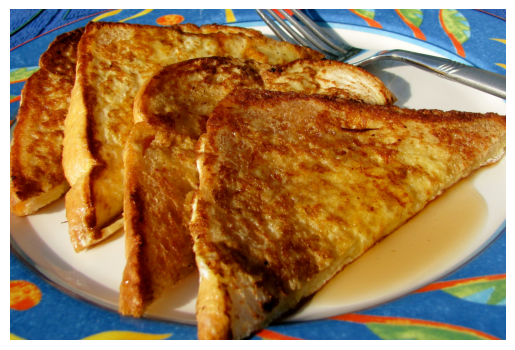

Title: French Toast
Ingredients:
2  slices    bread
1  egg
1/4 cup    milk
1/2 teaspoon    cinnamon
1/2 teaspoon    vanilla extract (optional)
1  teaspoon    butter or 1   teaspoon    margarine
Instructions:
1. Crack and Mix egg in a bowl.
2. Add the milk, cinnamon and the extract in bowl.
3. Mix together.
4. Heat a skilliet with the butter, on medium heat.
5. Dip BOTH sides of the bread in the egg mixture.
6. Then fry each side for 4 minutes.
7. Repeat the the second bread.
8. Serve.


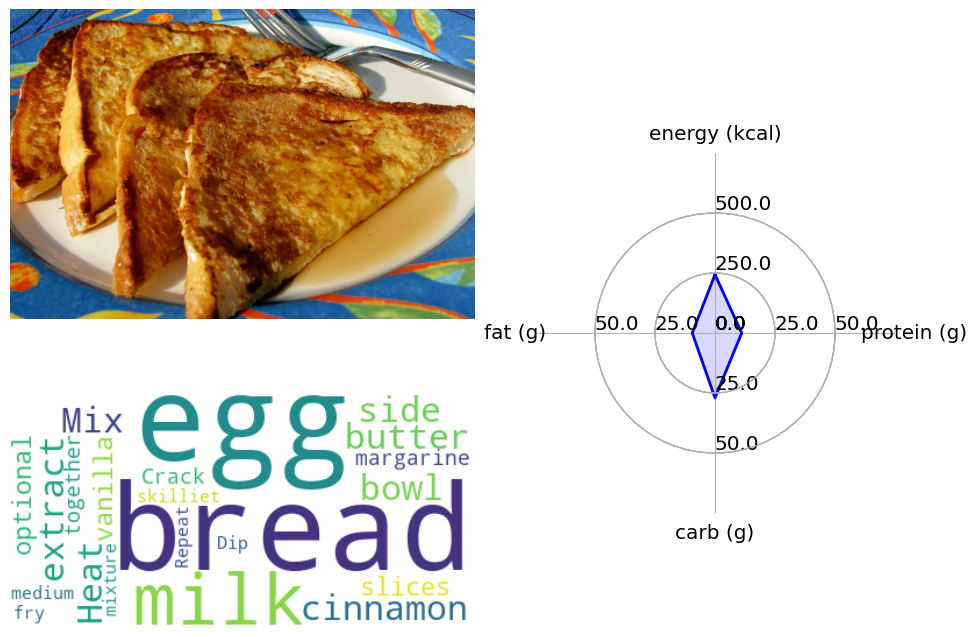

In [52]:
im2recipe = im2recipe_dict
idx = 18
print(idx)
query = random_queries[idx]

# query = 'recipes-4_00001581'
print(f'query: {query}')
total_nutr = nutr_per_recipes_total[query]
print(total_nutr)
plt.figure()
img = get_img(query)
plt.imshow(img)
plt.axis('off')
plt.show()

# word cloud
# title = layer1[query]['title']
# print(f'Title: {title}')
# print('Ingredients:')
# ingredients = layer1[query]['ingredients']
# ingredients_text = '\n'.join(ingredients)
# print(f'{ingredients_text}')
# print('Instructions:')
# instructions = layer1[query]['instructions']
# for inst_i, instruction in enumerate(instructions):
#     print(f'{inst_i+1}. {instruction}')
# all_text = '\n'.join([ingredients_text, *instructions])
# wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(all_text)
# plt.figure()
# plt.imshow(wordcloud)
# plt.axis('off')
# plt.show()



show_recipe_result_3(query)
# fig = plt.figure(figsize=(10,4))
# axs = fig.subplots(2,5)
# for idx, retrieved in enumerate(im2recipe[query][:10]):
#     img = get_img(retrieved)
#     axs[idx//5,idx%5].imshow(img)
#     axs[idx//5,idx%5].axis('off')
# plt.tight_layout()
# # plt.subplots_adjust(wspace=0)
# plt.show()
# for i, recipe_id in enumerate(retrieved):
#     print(f'Retrieved {i+1} id: {recipe_id}')
#     show_recipe_result(recipe_id)


In [39]:
# # prearation to cal noramlized iou

# ingredient_meds = {}

# for weighted_ingredients in weighted_food_ids_per_recipes.values():
#     for food_id, weight in zip(weighted_ingredients['food_id'], weighted_ingredients['weight']):
#         if food_id not in ingredient_meds.keys():
#             ingredient_meds[food_id] = []
#         ingredient_meds[food_id].append(weight)

# for food_id, weights in ingredient_meds.items():
#     ingredient_meds[food_id] = np.median(np.array(weights))

# with open("ingredient_meds.json","w") as f:
#     json.dump(ingredient_meds,f)

In [40]:
# # arrange by mase
# im2recipe_dict_mase = {}
# for recipe_id_i in im2recipe_dict.keys():
#     gt = nutr_per_recipes[recipe_id_i]
#     all_mase = {}
#     for recipe_id_j in im2recipe_dict.keys():
#         if recipe_id_i == recipe_id_j:
#             continue
#         pred = nutr_per_recipes[recipe_id_j]
#         _ , _, all_mase[recipe_id_j] = cal_mase(pred,gt)
#     sorted_targets = sorted(all_mase.keys(),key=lambda x : all_mase[x])[:50]
#     im2recipe_dict_mase[recipe_id_i] = list(sorted_targets)
# with open('im2recipe_dict_mase.json', 'w') as f:
#     json.dump(im2recipe_dict_mase, f, indent=2)

In [ ]:
# #arrange by iou
# im2recipe_dict_iou = {}
# for recipe_id_i in im2recipe_dict.keys():
#     gt = food_ids_per_recipes[recipe_id_i]
#     all_iou = {}
#     for recipe_id_j in im2recipe_dict.keys():
#         if recipe_id_i == recipe_id_j:
#             continue
#         pred = food_ids_per_recipes[recipe_id_j]
#         all_iou[recipe_id_j] = cal_iou(pred,gt)
#     sorted_targets = sorted(all_iou.keys(),key=lambda x : all_iou[x],reverse=True)[:50]
#     im2recipe_dict_iou[recipe_id_i] = list(sorted_targets)
#     # print(im2recipe_dict_iou)
#     # break
# with open('im2recipe_dict_iou.json', 'w') as f:
#     json.dump(im2recipe_dict_iou, f, indent=2)

In [ ]:
# #arrange by wiou
# im2recipe_dict_wiou = {}
# for recipe_id_i in im2recipe_dict.keys():
#     gt = food_ids_per_recipes[recipe_id_i]
#     gt_w = weighted_food_ids_per_recipes[recipe_id_i]['weight']
#     all_wiou = {}
#     for recipe_id_j in im2recipe_dict.keys():
#         if recipe_id_i == recipe_id_j:
#             continue
#         pred = food_ids_per_recipes[recipe_id_j]
#         pred_w = weighted_food_ids_per_recipes[recipe_id_j]['weight']
#         all_wiou[recipe_id_j] = cal_weighted_iou(pred,gt,pred_w,gt_w)
#     sorted_targets = sorted(all_wiou.keys(),key=lambda x : all_wiou[x],reverse=True)[:50]
#     im2recipe_dict_wiou[recipe_id_i] = list(sorted_targets)
#     # print(im2recipe_dict_iou)
#     # break
# with open('im2recipe_dict_wiou.json', 'w') as f:
#     json.dump(im2recipe_dict_wiou, f, indent=2)

In [31]:
# #arrange by wiou fixed
# im2recipe_dict_wiou = {}
# for recipe_id_i in im2recipe_dict.keys():
#     gt = food_ids_per_recipes[recipe_id_i]
#     gt_w = weighted_food_ids_per_recipes[recipe_id_i]['weight']
#     all_wiou = {}
#     for recipe_id_j in im2recipe_dict.keys():
#         if recipe_id_i == recipe_id_j:
#             continue
#         pred = food_ids_per_recipes[recipe_id_j]
#         pred_w = weighted_food_ids_per_recipes[recipe_id_j]['weight']
#         all_wiou[recipe_id_j] = cal_norm_weighted_iou(pred,gt,pred_w,gt_w)
#     sorted_targets = sorted(all_wiou.keys(),key=lambda x : all_wiou[x],reverse=True)[:50]
#     im2recipe_dict_wiou[recipe_id_i] = list(sorted_targets)
#     # print(im2recipe_dict_iou)
#     # break
# with open('im2recipe_dict_wiou_fixed.json', 'w') as f:
#     json.dump(im2recipe_dict_wiou, f, indent=2)

In [30]:
# #arrange by normalized wiou
# im2recipe_dict_norm_wiou = {}
# for recipe_id_i in im2recipe_dict.keys():
#     gt = food_ids_per_recipes[recipe_id_i]
#     gt_w = weighted_food_ids_per_recipes[recipe_id_i]['weight']
#     gt_norm_weight = [w/(ingredient_meds[str(food_id)]+1e-8) for w, food_id in zip(gt_w,gt)]
#     # found = False
#     # for food_id in gt:
#     #     if ingredient_meds[str(food_id)] == 0.:
#     #         print(recipe_id_i)
#     #         found = True
#     #         break
#     # if found:
#     #     break
#     all_wiou = {}
#     for recipe_id_j in im2recipe_dict.keys():
#         if recipe_id_i == recipe_id_j:
#             continue
#         pred = food_ids_per_recipes[recipe_id_j]
#         pred_w = weighted_food_ids_per_recipes[recipe_id_j]['weight']
#         pred_norm_weight = [w/(ingredient_meds[str(food_id)]+1e-8) for w, food_id in zip(pred_w,pred)]
#         all_wiou[recipe_id_j] = cal_norm_weighted_iou(pred,gt,pred_norm_weight,gt_norm_weight)
#     sorted_targets = sorted(all_wiou.keys(),key=lambda x : all_wiou[x],reverse=True)[:50]
#     im2recipe_dict_norm_wiou[recipe_id_i] = list(sorted_targets)
#     # print(im2recipe_dict_iou)
#     # break
# with open('im2recipe_dict_norm_wiou.json', 'w') as f:
#     json.dump(im2recipe_dict_norm_wiou, f, indent=2)

In [ ]:
# energy_list = []
# fat_list = []
# carb_list = []
# protein_list = []
# for recipe_id, nutr in nutr_per_recipes.items():
#     energy_list.append(nutr['energy'])
#     fat_list.append(nutr['fat'])
#     carb_list.append(nutr['carb'])
#     protein_list.append(nutr['protein'])
# energy_max = max(energy_list)
# fat_max = max(fat_list)
# carb_max = max(carb_list)
# protein_max = max(protein_list)
# print(f'energy:{energy_max}')
# print(f'fat:{fat_max}')
# print(f'carb:{carb_max}')
# print(f'protein:{protein_max}')


In [8]:
# queries = list(im2recipe_dict.keys())
# random_queries = random.choices(queries,k=100)
# with open('random_queries.json','w') as f:
#     json.dump(random_queries,f)

In [7]:
# queries_all = list(im2recipe_dict.keys())
# with open('queries_all.json','w') as f:
#     json.dump(queries_all,f)

In [31]:
def cal_iou(input_1, input_2):
    input_1 = set(input_1)
    input_2 = set(input_2)
    u = input_1.union(input_2)
    i = input_1.intersection(input_2)
    return len(i) / len(u)

def cal_weighted_iou(input_1, input_2, w_1, w_2):
    all_weight = sum(w_1) + sum(w_2)
    intersect_weight = 0.
    for i, ingr in enumerate(input_1):
        if ingr in input_2:
            j = input_2.index(ingr)
            intersect_weight += w_1[i] + w_2[j]
    return intersect_weight / (all_weight + 1e-8)

def cal_norm_weighted_iou(input_1, input_2, w_1, w_2):
    all_weight = sum(w_1) + sum(w_2)
    intersect_weight = 0.
    for i, ingr in enumerate(input_1):
        if ingr in input_2:
            j = input_2.index(ingr)
            intersect_weight += min(w_1[i],w_2[j])
            all_weight -= min(w_1[i],w_2[j])
    return intersect_weight / (all_weight + 1e-8)

def cal_mean_iou(im2recipe_dict,food_ids_per_recipes,weighted_food_ids_per_recipes):
    ious = []
    weighted_ious = []
    for recipe_id, results in im2recipe_dict.items():
        result = results[0]
        ious.append(cal_iou(food_ids_per_recipes[recipe_id],food_ids_per_recipes[result]))
        weighted_ious.append(cal_weighted_iou(food_ids_per_recipes[recipe_id],food_ids_per_recipes[result],weighted_food_ids_per_recipes[recipe_id]['weight'],weighted_food_ids_per_recipes[result]['weight']))
    iou = sum(ious)/len(ious) * 100
    weighted_iou = sum(weighted_ious)/len(weighted_ious) * 100
    return iou, weighted_iou

def cal_mase(pred, gt):
    # ms = {'energy': 211.98462376370378, 'fat': 10.765786025555727, 'carb': 22.87488284825082, 'protein': 6.497832050027167}
    mads = {'energy': 100.39411644302027, 'fat': 7.139428395140109, 'carb': 15.985982100326039, 'protein': 3.841522669109835}
    aes = {}
    ases = {}
    for nutr_name in gt.keys():
        aes[nutr_name] = abs(pred[nutr_name] - gt[nutr_name])
        ases[nutr_name] = aes[nutr_name] / mads[nutr_name]
    mase = sum(list(ases.values()))/len(list(gt.keys()))
    return aes, ases, mase

In [26]:
# dir = 'vlp/org_finetuned_recipe1m+/_recipe_only'
# recipe2recipe = np.load(f'../out/models/{dir}/recipe2recipe.npy')
# with open(f'../out/models/{dir}/img_path','rb') as f:
#     img_path = pickle.load(f)
# with open(f'../out/models/{dir}/saved_ids','rb') as f:
#     saved_ids = pickle.load(f)
# recipe2recipe_dict = {}
# for i, sorted_recipe in enumerate(recipe2recipe):
#     avail_sorted_recipe = [saved_ids[idx] for idx in sorted_recipe if idx != i][:50]
#     recipe2recipe_dict[saved_ids[i]] = avail_sorted_recipe
# save_path = f'results_recipe2recipe/{dir}.json'
# os.makedirs(os.path.dirname(save_path),exist_ok=True)
# with open(save_path,'w') as f:
#     json.dump(recipe2recipe_dict,f,indent=2)

In [32]:
import scipy

im2recipe = im2recipe_dict

mean_mases = []
med_mases = []
corr_r_mases = []
corr_t_mases = []
mean_ious = []
med_ious = []
corr_r_ious = []
corr_t_ious = []
mean_wious = []
med_wious = []
corr_r_wious = []
corr_t_wious = []

for idx in range(len(queries_all)):
    # print(idx)
    query = queries_all[idx]
    # print(f'query: {query}')
    retrieved = im2recipe[query]
    gt_nutr = nutr_per_recipes[query]
    gt_ingr = food_ids_per_recipes[query]
    gt_w = weighted_food_ids_per_recipes[query]['weight']
    mases = []
    ious = []
    wious = []
    for i, recipe_id in enumerate(retrieved):
        pred_nutr = nutr_per_recipes[recipe_id]
        pred_ingr = food_ids_per_recipes[recipe_id]
        pred_w = weighted_food_ids_per_recipes[recipe_id]['weight']
        _,_,mase = cal_mase(pred_nutr,gt_nutr)
        iou = cal_iou(pred_ingr,gt_ingr)
        wiou = cal_weighted_iou(pred_ingr,gt_ingr,pred_w,gt_w)
        mases.append(mase)
        ious.append(iou)
        wious.append(wiou)

    mean_mases.append(np.array(mases).mean())
    mean_ious.append(np.array(ious).mean())
    mean_wious.append(np.array(wious).mean())

    med_mases.append(np.median(np.array(mases)))
    med_ious.append(np.median(np.array(ious)))
    med_wious.append(np.median(np.array(wious)))

    rank_mase = np.argsort(np.argsort(np.array(mases)))
    rank_ious = np.argsort(np.flip(np.argsort(np.array(ious))))
    rank_wious = np.argsort(np.flip(np.argsort(np.array(wious))))
    mase_r = scipy.stats.spearmanr(range(len(rank_mase)),rank_mase)[0]
    mase_t = scipy.stats.kendalltau(range(len(rank_mase)),rank_mase)[0]
    iou_r = scipy.stats.spearmanr(range(len(rank_ious)),rank_ious)[0]
    iou_t = scipy.stats.kendalltau(range(len(rank_ious)),rank_ious)[0]
    wiou_r = scipy.stats.spearmanr(range(len(rank_wious)),rank_wious)[0]
    wiou_t = scipy.stats.kendalltau(range(len(rank_wious)),rank_wious)[0]

    corr_r_mases.append(mase_r)
    corr_t_mases.append(mase_t)
    corr_r_ious.append(iou_r)
    corr_t_ious.append(iou_t)
    corr_r_wious.append(wiou_r)
    corr_t_wious.append(wiou_t)

In [33]:
best_mean_mases = [queries_all[i] for i in np.argsort(np.array(mean_mases))]
best_corrs_mases = [queries_all[i] for i in np.flip(np.argsort(np.array(corr_r_mases)))]
best_mean_ious = [queries_all[i] for i in np.flip(np.argsort(np.array(mean_ious)))]
best_corrs_ious = [queries_all[i] for i in np.flip(np.argsort(np.array(corr_r_ious)))]
best_mean_wious = [queries_all[i] for i in np.flip(np.argsort(np.array(mean_wious)))]
best_corrs_wious = [queries_all[i] for i in np.flip(np.argsort(np.array(corr_r_wious)))]

In [34]:
nutr_per_recipes["recipes-6_00009491"]

{'energy': 163.70169443257868,
 'fat': 2.0894821776069104,
 'carb': 31.954519910769374,
 'protein': 3.7407622573449135}

In [ ]:
import torchvision.transforms.functional as TF

with open('results/reranked_100/deep_ht/direct_ingrs_3_branches/base/food_test_recipe_only.json') as f:
# with open('results/reranked_100_weighted/deep_ht/direct_ingrs_3_branches/no_nutr/food_test_recipe_only/0.3.json') as f:
    im2recipe_rerank = json.load(f)

# example = "recipes-1_00010017"
# example = "recipes-6_00013699"
# example = "recipes-1_00006336"
# example = "recipes-5_00006361" #brownie
# example = "recipes-5_00002907" #mustard
# example = "recipes-3_00000209" #pistachio milk
example = "recipes-6_00009491" #custard
# example = "recipes-4_00013431" #spinach dip

#good ones
# example = "recipes-7_00013172"

#mids
# example = "recipes-6_00002841" #macaroni !!
# example = "recipes-8_00006723" # pork adobo !
# example = "recipes-8_00004637" #chili yogurt mushroom
# example = "recipes-8_00014630" #burnt almond cocktail
# example = "recipes-3_00004841" #mango chicken
# example = "recipes-3_00004374" #lentil spinach soup !
# example = "recipes-3_00001483" #chicken salsa !
# example = "recipes-9_00000794" #herb ham & cheddar fretata
# example = "recipes-4_00000606" #Cincinnati Chili
# example = "recipes-5_00011263" # italian eggplant !!

print(f'id: {example}')
plt.figure()
img = get_img(example)
img = TF.resize(img,[1536,2048])
plt.imshow(img)
plt.axis('off')
plt.show()
show_recipe_result(example)
# plot radar chart
fig = plt.figure()
nutr = nutr_per_recipes[example]
# fig = plt.figure(figsize=(6, 6))
radar = Radar(fig, labels, max_values, num_ticks = 3)
# print([nutr['energy'],nutr['fat'],nutr['carb'],nutr['protein']])
radar.plot([nutr['energy'],nutr['fat'],nutr['carb'],nutr['protein']],  "-", lw=2, color="b")
plt.show()
plt.close()
fig = plt.figure(figsize=(10,4))
axs = fig.subplots(2,5)
retrieves = im2recipe[example][:10]
retrieves = [rec for rec in retrieves if rec != example]
mases = []
for idx, retrieved in enumerate(retrieves[:5]):
    mase = cal_mase(nutr_per_recipes[retrieved],nutr_per_recipes[example])[2]
    mases.append(mase)
    img = get_img(retrieved)
    img = TF.resize(img,[1536,2048])
    axs[0,idx].imshow(img)
    # axs[0,idx].set_title(f"{idx+1}a) MASE={mase:.04f}",fontsize='x-large')
    axs[0,idx].axis('off')
    title = layer1[retrieved]['title']
    print(f'{idx+1}a) {title}')
print(np.array(mases).mean())
# plt.tight_layout()
# plt.subplots_adjust(wspace=0)
# plt.show()

# fig = plt.figure(figsize=(4,6))
# axs = fig.subplots(3,2)
mases = []
retrieves = im2recipe_rerank[example][:10]
retrieves = [rec for rec in retrieves if rec != example]
for idx, retrieved in enumerate(retrieves[:5]):
    mase = cal_mase(nutr_per_recipes[retrieved],nutr_per_recipes[example])[2]
    mases.append(mase)
    img = get_img(retrieved)
    img = TF.resize(img,[1536,2048])
    axs[1,idx].imshow(img)
    # axs[1,idx].set_title(f"{idx+1}b) MASE={mase:.04f}",fontsize='x-large')
    axs[1,idx].axis('off')
    title = layer1[retrieved]['title']
    print(f'{idx+1}b) {title}')
print(np.array(mases).mean())
plt.tight_layout()
# plt.subplots_adjust(wspace=0)
plt.show()

retrieves = im2recipe[example][:10]
retrieves = [rec for rec in retrieves if rec != example]
plt.figure()
img = get_img(retrieves[0])
img = TF.resize(img,[1536,2048])
plt.imshow(img)
plt.axis('off')
plt.show()
plt.close()
show_recipe_result(retrieves[0])


# plot radar chart
# also get the csv data
data_dict = {'recipe': [], 'Energy': [], 'Fat': [], 'Carb': [], 'Protein': [], 'MASE': []}

for i in range(5):
    fig = plt.figure()
    nutr = nutr_per_recipes[retrieves[i]]
    data_dict['recipe'].append(layer1[retrieves[i]]['title'])
    data_dict['Energy'].append(nutr['energy'])
    data_dict['Fat'].append(nutr['fat'])
    data_dict['Carb'].append(nutr['carb'])
    data_dict['Protein'].append(nutr['protein'])
    data_dict['MASE'].append(cal_mase(nutr,nutr_per_recipes[example])[2])
    # fig = plt.figure(figsize=(6, 6))
    radar = Radar(fig, ['']*4, max_values,num_ticks = 3)
    # print([nutr['energy'],nutr['fat'],nutr['carb'],nutr['protein']])
    radar.plot([nutr['energy'],nutr['fat'],nutr['carb'],nutr['protein']],  "-", lw=2, color="b")
    plt.show()
    plt.close()

#rerank
retrieves = im2recipe_rerank[example][:10]
retrieves = [rec for rec in retrieves if rec != example]
plt.figure()
img = get_img(retrieves[0])
img = TF.resize(img,[1536,2048])
plt.imshow(img)
plt.axis('off')
plt.show()
plt.close()
show_recipe_result(retrieves[0])
# plot radar chart
for i in range(5):
    fig = plt.figure()
    nutr = nutr_per_recipes[retrieves[i]]
    data_dict['recipe'].append(layer1[retrieves[i]]['title'])
    data_dict['Energy'].append(nutr['energy'])
    data_dict['Fat'].append(nutr['fat'])
    data_dict['Carb'].append(nutr['carb'])
    data_dict['Protein'].append(nutr['protein'])
    data_dict['MASE'].append(cal_mase(nutr,nutr_per_recipes[example])[2])
    # fig = plt.figure(figsize=(6, 6))
    radar = Radar(fig, ['']*4, max_values,num_ticks = 3)
    # print([nutr['energy'],nutr['fat'],nutr['carb'],nutr['protein']])
    radar.plot([nutr['energy'],nutr['fat'],nutr['carb'],nutr['protein']],  "-", lw=2, color="b")
    plt.show()
    plt.close()

In [41]:
import pandas as pd
output_df = pd.DataFrame.from_dict(data_dict)
output_df.to_csv('../md_thesis/qual_nutr.csv')

In [42]:
print(nutr_per_recipes[example])

{'energy': 111.09387032397986, 'fat': 2.7514102928702666, 'carb': 17.808937056261854, 'protein': 5.076900701573035}


In [ ]:
import scipy

im2recipe = im2recipe_dict

fig = plt.figure(figsize=(12,6))
mase_fig, iou_fig, wiou_fig = fig.subfigures(3,1)
mase_fig.suptitle('Nutrition MASE')
# mase_fig.supxlabel('retrieved rank')
# mase_fig.supylabel('gt rank')
mase_fig.supylabel('MASE from GT')
mase_sub_figs = mase_fig.subplots(1,4)
iou_fig.suptitle('Ingredient IOU')
iou_fig.supylabel('IOU with GT')
# iou_fig.supxlabel('retrieved rank')
iou_fig.supylabel('gt rank')
iou_sub_figs = iou_fig.subplots(1,4)
wiou_fig.suptitle('Ingredient WIOU')
wiou_fig.supylabel('WIOU with GT')
# wiou_fig.supxlabel('retrieved rank')
wiou_fig.supylabel('gt rank')
wiou_sub_figs = wiou_fig.subplots(1,4)

offset = 0

for idx in range(4):
    # print(idx)
    # query = random_queries[idx + offset]
    # query = best_mean_mases[idx + offset]
    query = best_corrs_ious[-1 - (idx + offset)]
    # print(f'query: {query}')
    retrieved = im2recipe[query]
    gt_nutr = nutr_per_recipes[query]
    gt_ingr = food_ids_per_recipes[query]
    gt_w = weighted_food_ids_per_recipes[query]['weight']
    mases = []
    ious = []
    wious = []
    for i, recipe_id in enumerate(retrieved):
        pred_nutr = nutr_per_recipes[recipe_id]
        pred_ingr = food_ids_per_recipes[recipe_id]
        pred_w = weighted_food_ids_per_recipes[recipe_id]['weight']
        _,_,mase = cal_mase(pred_nutr,gt_nutr)
        iou = cal_iou(pred_ingr,gt_ingr)
        wiou = cal_weighted_iou(pred_ingr,gt_ingr,pred_w,gt_w)
        mases.append(mase)
        ious.append(iou)
        wious.append(wiou)
    rank_mase = np.argsort(np.argsort(np.array(mases)))
    rank_ious = np.argsort(np.flip(np.argsort(np.array(ious))))
    rank_wious = np.argsort(np.flip(np.argsort(np.array(wious))))
    mase_r = scipy.stats.spearmanr(range(len(rank_mase)),rank_mase)[0]
    mase_t = scipy.stats.kendalltau(range(len(rank_mase)),rank_mase)[0]
    iou_r = scipy.stats.spearmanr(range(len(rank_ious)),rank_ious)[0]
    iou_t = scipy.stats.kendalltau(range(len(rank_ious)),rank_ious)[0]
    wiou_r = scipy.stats.spearmanr(range(len(rank_wious)),rank_wious)[0]
    wiou_t = scipy.stats.kendalltau(range(len(rank_wious)),rank_wious)[0]
    # mase_sub_figs[idx//3,idx%3].plot(range(len(rank_mase)),rank_mase)
    mase_sub_figs[idx%4].plot(range(len(rank_mase)),rank_mase)
    # mase_sub_figs[idx//3,idx%3].set_title(f"p = {mase_r:.02f}, t = {mase_t:.02f}")
    mase_sub_figs[idx%4].set_title(f"recipe {idx}")
    mase_sub_figs[idx%4].set_xlabel(f"retrieved rank")
    if idx != 0:
        mase_sub_figs[idx%4].set_yticklabels([])
    # iou_sub_figs[idx//3,idx%3].plot(range(len(rank_ious)),rank_ious)
    iou_sub_figs[idx%4].plot(range(len(rank_ious)),rank_ious)
    # iou_sub_figs[idx//3,idx%3].set_title(f"p = {iou_r:.02f}, t = {iou_t:.02f}")
    iou_sub_figs[idx%4].set_title(f"recipe {idx}")
    iou_sub_figs[idx%4].set_xlabel(f"retrieved rank")
    if idx != 0:
        iou_sub_figs[idx%4].set_yticklabels([])
    # wiou_sub_figs[idx//3,idx%3].plot(range(len(rank_wious)),rank_wious)
    wiou_sub_figs[idx%4].plot(range(len(rank_wious)),rank_wious)
    # wiou_sub_figs[idx//3,idx%3].set_title(f"p = {wiou_r:.02f}, t = {wiou_t:.02f}")
    wiou_sub_figs[idx%4].set_title(f"recipe {idx}")
    wiou_sub_figs[idx%4].set_xlabel(f"retrieved rank")
    if idx != 0:
        wiou_sub_figs[idx%4].set_yticklabels([])
# mase_fig.tight_layout()
fig.tight_layout()
plt.subplots_adjust(top=0.8,bottom=0.2,wspace=0)
plt.show()

In [181]:
dir = 'vlp/org_finetuned_recipe1m+/_recipe_only'
recipe2recipe = np.load(f'../out/models/{dir}/recipe2recipe.npy')
r2r_distances = np.load(f'../out/models/{dir}/r2rdistances.npy')
with open(f'../out/models/{dir}/img_path','rb') as f:
    img_path = pickle.load(f)
with open(f'../out/models/{dir}/saved_ids','rb') as f:
    saved_ids = pickle.load(f)


In [182]:
reverse_saved_ids = {}
for i, saved_id in enumerate(saved_ids):
    reverse_saved_ids[saved_id] = i

In [ ]:
im2recipe = im2recipe_dict_vlp


def cal_dist(k):
    distances = []
    for recipe_id, results in im2recipe.items():
        for result in results[:k]:
            dist = r2r_distances[reverse_saved_ids[recipe_id],reverse_saved_ids[result]]
            distances.append(dist)
    return np.array(distances).mean()


for k in [1,5,10,20]:
    print(cal_dist(k))

In [ ]:
im2recipe = im2recipe_dict

fig = plt.figure(figsize=(10,7))
fig.suptitle('Text Embedding Similarity')
fig.supxlabel('retrieved rank')
fig.supylabel('gt rank')
txt_sub_figs = fig.subplots(2,3)

for idx in range(6):
    # print(idx)
    query = random_queries[idx]
    # print(f'query: {query}')
    retrieved = im2recipe[query]
    distances = []
    for i, recipe_id in enumerate(retrieved):
        dist = r2r_distances[reverse_saved_ids[query],reverse_saved_ids[recipe_id]]
        distances.append(dist)
    rank_dist = np.argsort(np.argsort(np.array(distances)))
    dist_r = scipy.stats.spearmanr(range(len(rank_dist)),rank_dist)[0]
    dist_t = scipy.stats.kendalltau(range(len(rank_dist)),rank_dist)[0]
    txt_sub_figs[idx//3,idx%3].plot(range(len(rank_dist)),rank_dist)
    txt_sub_figs[idx//3,idx%3].set_title(f"p = {dist_r:.02f}, t = {dist_t:.02f}")
# mase_fig.tight_layout()
fig.tight_layout()
plt.subplots_adjust(top=0.9,bottom=0.1)
plt.show()

In [ ]:
# best corrs_mases

for i in range(4):
    example = best_corrs_mases[i]
    print(f'id: {example}')
    plt.figure()
    img = get_img(example)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    show_recipe_result(example)
    fig = plt.figure(figsize=(4,6))
    axs = fig.subplots(3,2)
    for idx, retrieved in enumerate(im2recipe[example][:6]):
        img = get_img(retrieved)
        axs[idx//2,idx%2].imshow(img)
        axs[idx//2,idx%2].axis('off')
    plt.tight_layout()
    # plt.subplots_adjust(wspace=0)
    plt.show()


In [ ]:
# best mean_mases

for i in range(4):
    example = best_mean_mases[i]
    print(f'id: {example}')
    plt.figure()
    img = get_img(example)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    show_recipe_result(example)
    fig = plt.figure(figsize=(4,6))
    axs = fig.subplots(3,2)
    for idx, retrieved in enumerate(im2recipe[example][:6]):
        img = get_img(retrieved)
        axs[idx//2,idx%2].imshow(img)
        axs[idx//2,idx%2].axis('off')
    plt.tight_layout()
    # plt.subplots_adjust(wspace=0)
    plt.show()

In [ ]:
# best iou corr

for i in range(4):
    example = best_corrs_ious[i]
    print(f'id: {example}')
    plt.figure()
    img = get_img(example)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    show_recipe_result(example)
    fig = plt.figure(figsize=(4,6))
    axs = fig.subplots(3,2)
    for idx, retrieved in enumerate(im2recipe[example][:6]):
        img = get_img(retrieved)
        axs[idx//2,idx%2].imshow(img)
        axs[idx//2,idx%2].axis('off')
    plt.tight_layout()
    # plt.subplots_adjust(wspace=0)
    plt.show()

In [ ]:
# best iou mean

for i in range(4):
    example = best_mean_ious[i]
    plt.figure()
    img = get_img(example)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    print(f'id: {example}')
    show_recipe_result(example)

In [ ]:
# worst corrs_mases

for i in range(10):
    example = best_corrs_mases[-21-i]
    print(f'id: {example}')
    plt.figure()
    img = get_img(example)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    show_recipe_result(example)
    fig = plt.figure(figsize=(4,6))
    axs = fig.subplots(3,2)
    for idx, retrieved in enumerate(im2recipe[example][:6]):
        img = get_img(retrieved)
        axs[idx//2,idx%2].imshow(img)
        axs[idx//2,idx%2].axis('off')
    plt.tight_layout()
    # plt.subplots_adjust(wspace=0)
    plt.show()

In [ ]:
# worst mean_mases

for i in range(10):
    example = best_mean_mases[-1-i]
    print(f'id: {example}')
    plt.figure()
    img = get_img(example)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    show_recipe_result(example)
    fig = plt.figure(figsize=(4,6))
    axs = fig.subplots(3,2)
    for idx, retrieved in enumerate(im2recipe[example][:6]):
        img = get_img(retrieved)
        axs[idx//2,idx%2].imshow(img)
        axs[idx//2,idx%2].axis('off')
    plt.tight_layout()
    # plt.subplots_adjust(wspace=0)
    plt.show()

In [ ]:
# worst corr_ious

for i in range(4):
    example = best_corrs_ious[-1-i]
    print(f'id: {example}')
    plt.figure()
    img = get_img(example)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    show_recipe_result(example)
    fig = plt.figure(figsize=(4,6))
    axs = fig.subplots(3,2)
    for idx, retrieved in enumerate(im2recipe[example][:6]):
        img = get_img(retrieved)
        axs[idx//2,idx%2].imshow(img)
        axs[idx//2,idx%2].axis('off')
    plt.tight_layout()
    # plt.subplots_adjust(wspace=0)
    plt.show()
    fig = plt.figure(figsize=(4,6))
    axs = fig.subplots(3,2)
    for idx, retrieved in enumerate(im2recipe_dict_mase[example][:6]):
        img = get_img(retrieved)
        axs[idx//2,idx%2].imshow(img)
        axs[idx//2,idx%2].axis('off')
    plt.tight_layout()
    # plt.subplots_adjust(wspace=0)
    plt.show()

In [ ]:
# worst mean_ious

for i in range(10):
    example = best_mean_ious[-1-i]
    print(f'id: {example}')
    plt.figure()
    img = get_img(example)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    show_recipe_result(example)
    fig = plt.figure(figsize=(4,6))
    axs = fig.subplots(3,2)
    for idx, retrieved in enumerate(im2recipe[example][:6]):
        img = get_img(retrieved)
        axs[idx//2,idx%2].imshow(img)
        axs[idx//2,idx%2].axis('off')
    plt.tight_layout()
    # plt.subplots_adjust(wspace=0)
    plt.show()
    fig = plt.figure(figsize=(4,6))
    axs = fig.subplots(3,2)
    for idx, retrieved in enumerate(im2recipe_dict_mase[example][:6]):
        img = get_img(retrieved)
        axs[idx//2,idx%2].imshow(img)
        axs[idx//2,idx%2].axis('off')
    plt.tight_layout()
    # plt.subplots_adjust(wspace=0)
    plt.show()

In [ ]:
# mid corrs_mases

for i in range(4):
    example = best_corrs_mases[i + 4000]
    print(f'id: {example}')
    plt.figure()
    img = get_img(example)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    show_recipe_result(example)
    fig = plt.figure(figsize=(4,6))
    axs = fig.subplots(3,2)
    for idx, retrieved in enumerate(im2recipe[example][:6]):
        img = get_img(retrieved)
        axs[idx//2,idx%2].imshow(img)
        axs[idx//2,idx%2].axis('off')
    plt.tight_layout()
    # plt.subplots_adjust(wspace=0)
    plt.show()


id: recipes-9_00000794


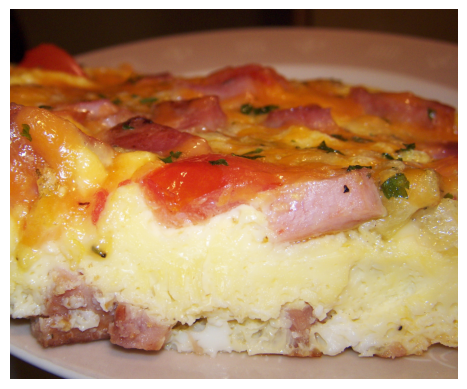

Title: Herbed Ham and Cheddar Frittata
Ingredients:
1/2 small    onion, minced
1  clove    garlic, minced
1  tablespoon    olive oil
4  large    eggs
1  teaspoon    fresh thyme leave, minced,or 1/4 teaspoon dried,crumbled
1  teaspoon    fresh rosemary leaf, minced,or 1/4 teaspoon dried,crumbled
 freshly ground black pepper
1/4 lb    ham steak, chopped  (about 3/4 cup)
1/3 cup   grated extra-sharp cheddar cheese
1  tablespoon   minced fresh parsley leaves
Instructions:
1. In an 8- or 9-inch flameproof heavy skillet cook onions and garlic in oil over moderately low heat, stirring, until softened.
2. In a bowl whisk together eggs, thyme, rosemary and pepper to taste.
3. Add egg mixture to onion mixture and cook, without stirring, 2 minutes.
4. Add ham and cook, without stirring, 8 minutes, or until edges are set but center is still soft.
5. While frittata is cooking, preheat broiler.
6. Sprinkle Cheddar on frittata and broil about 4 inches from heat until cheese is bubbling, about 1 minut

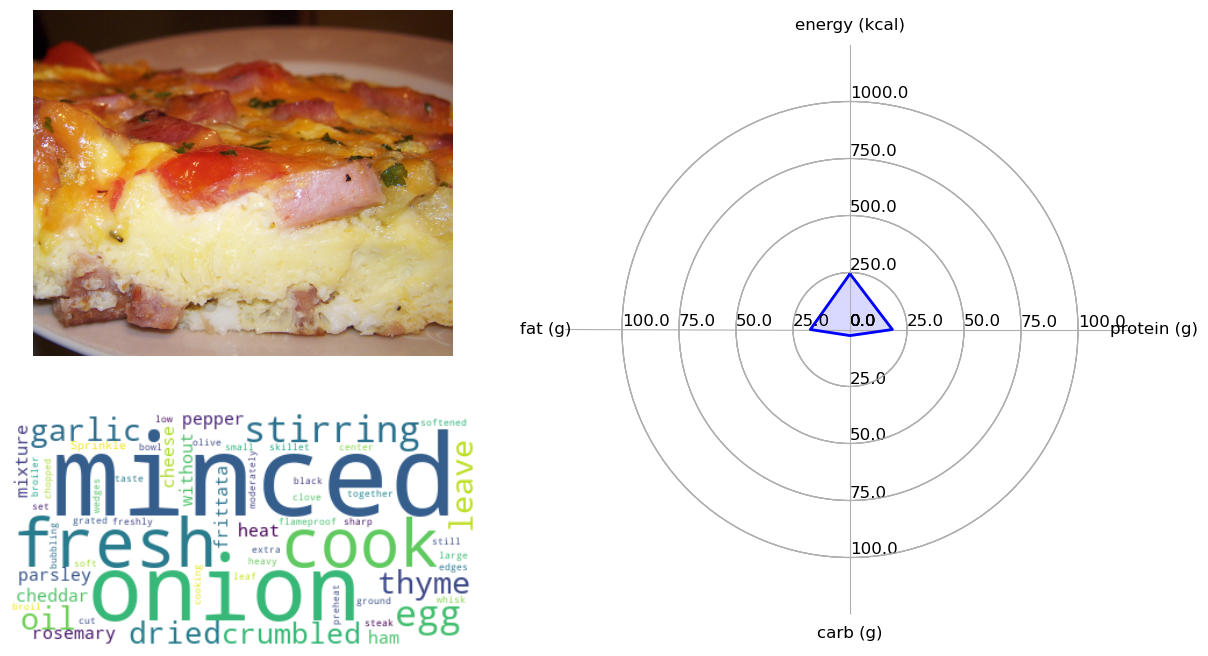

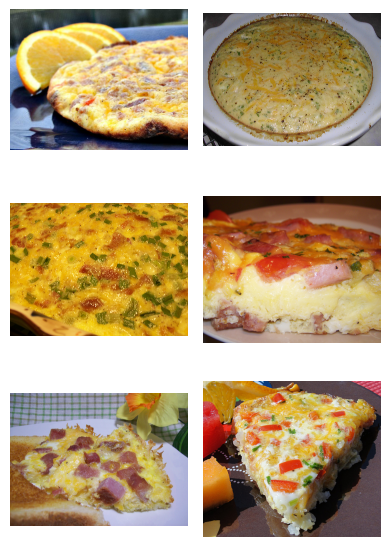

id: recipes-4_00000606


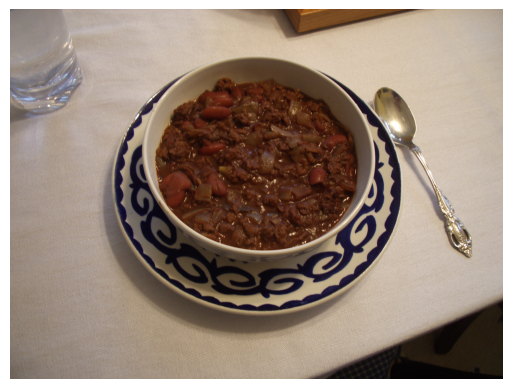

Title: Cincinnati Chili
Ingredients:
1  lb    ground beef
1  lb    ground pork
4  medium    onions, chopped
6  garlic cloves, minced
32  ounces    kidney beans, rinsed and drained
28  ounces    crushed tomatoes
1/4 cup    white vinegar
1/4 cup    baking cocoa
2  tablespoons    chili powder
2  tablespoons    worcestershire sauce
4  teaspoons    ground cinnamon
3  teaspoons    dried oregano
2  teaspoons    ground cumin
2  teaspoons    ground allspice
2  teaspoons    hot pepper sauce
3  bay leaves
1  teaspoon    sugar
 salt and pepper
Instructions:
1. In a Dutch oven, cook the beef, pork and onions over medium heat until meat is no longer pink.
2. Add garlic; cook 1 minute longer. Drain.
3. Add the beans, tomatoes, vinegar, cocoa and seasonings; bring to a boil.
4. Reduce heat; cover and simmer for 1-1/2 hours or until heated through.
5. Fish out and throw away bay leaves.
6. Optional: Serve with spaghetti, or garnish with cheese, sour cream, tomatoes and onions.


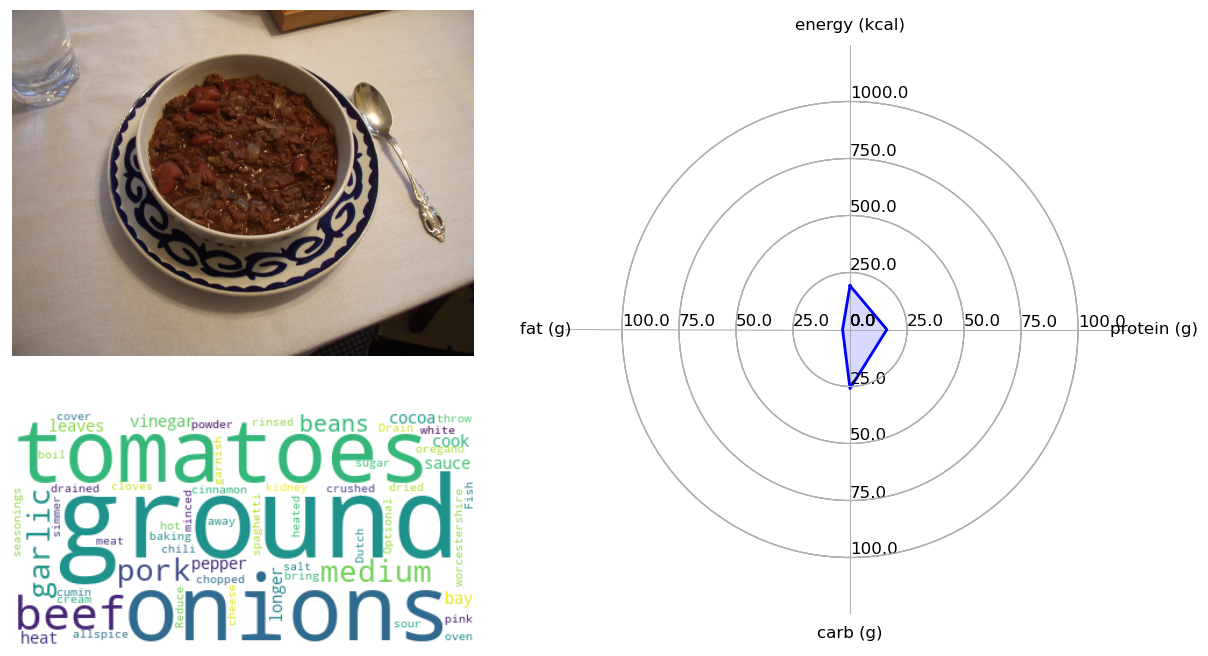

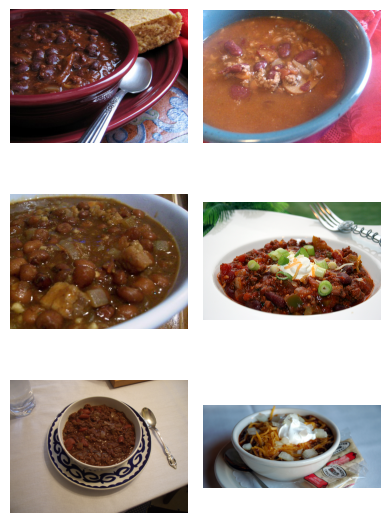

id: recipes-5_00011263


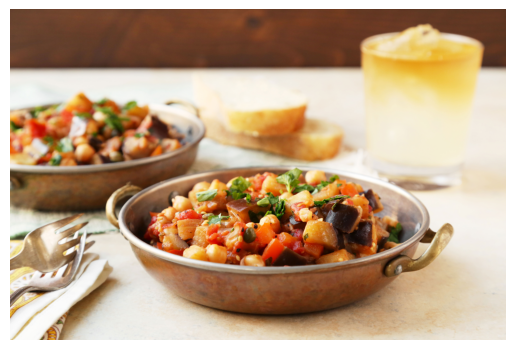

Title: Italian Eggplant Ragout
Ingredients:
2  medium    eggplants, halved
2  tablespoons    salt
2  tablespoons    olive oil
1  large    onion, chopped
2  garlic cloves, minced
1 (15   ounce) can   diced tomatoes, drained
1 (15   ounce) can   chickpeas, rinsed and drained
2  tablespoons    capers
1  teaspoon    sugar
1/4 cup    parsley, chopped
Instructions:
1. Scoop out center and seeds of eggplant halves. Cut eggplants into 3/4 inch dice. Toss with salt in bowl and let it stand for at least 20 minutes. Drain off the fluid that collects, rinse well, and pat dry.
2. Heat olive oil in large saucepan over medium heat. Add onion, and saute until softened (about 5 minutes.) Add garlic, and cook 1 minute more, or until fragrant. Stir in tomatoes, chickpeas, and eggplants. Reduce heat to medium-low, and cook 15 minutes, or until eggplants are tender but not mushy.
3. Stir in capers and sugar, and cook 2 minutes more. Fold in parsley, and season with black pepper.


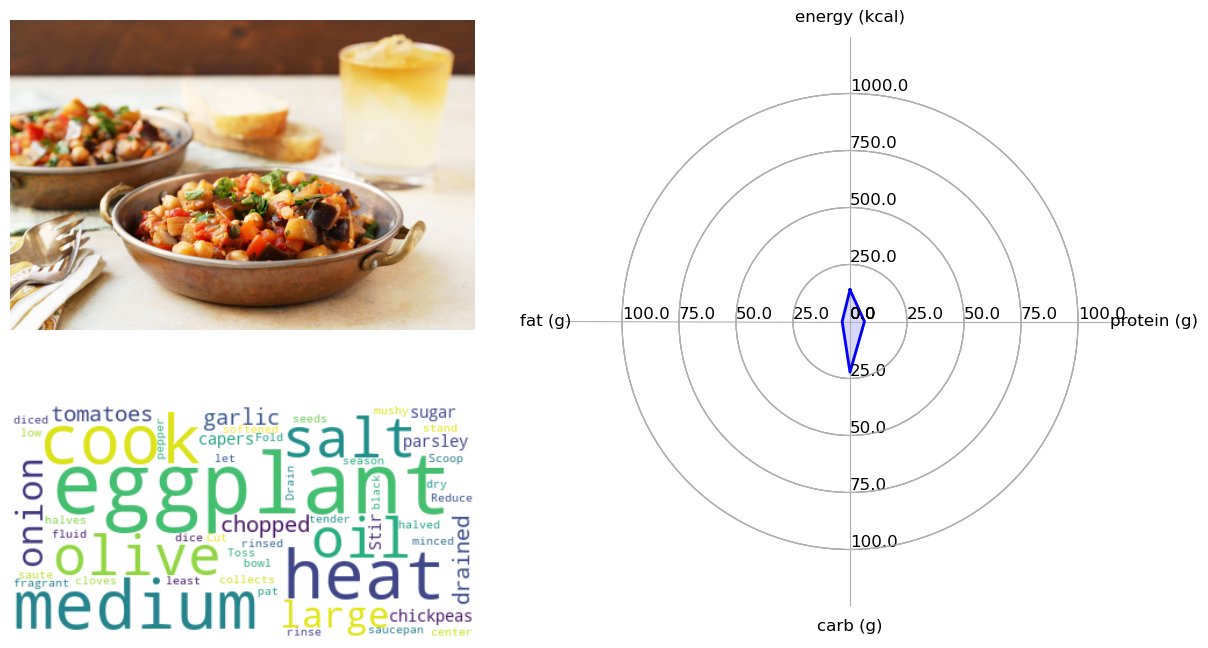

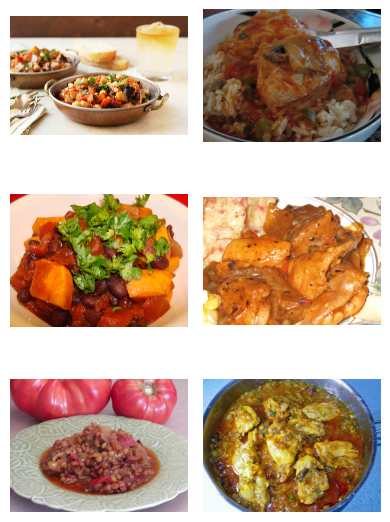

id: recipes-10_00003302


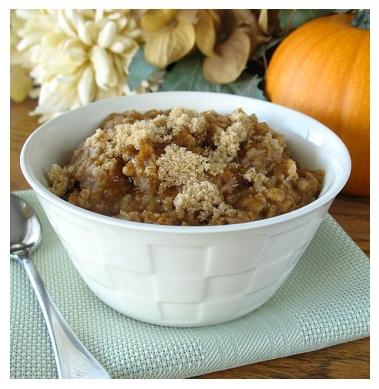

Title: Pumpkin Oatmeal
Ingredients:
1/2 cup    old fashioned oats (example quaker oats)
1  cup    water
1/8 cup    pumpkin
1  teaspoon    pumpkin pie spice
1  tablespoon    brown sugar
1 (1   g) packet   splenda sugar substitute
Instructions:
1. In a bowl, combine all ingredients.
2. Add some chopped nuts, if desired.
3. Microwave oatmeal for 2-3 minutes depending on your microwave.
4. Be careful of the oatmeal boiling over.
5. This could also be done on a stovetop, campfire, or in a slow cooker.
6. Give your oatmeal a good stir and enjoy with some flavored coffee.


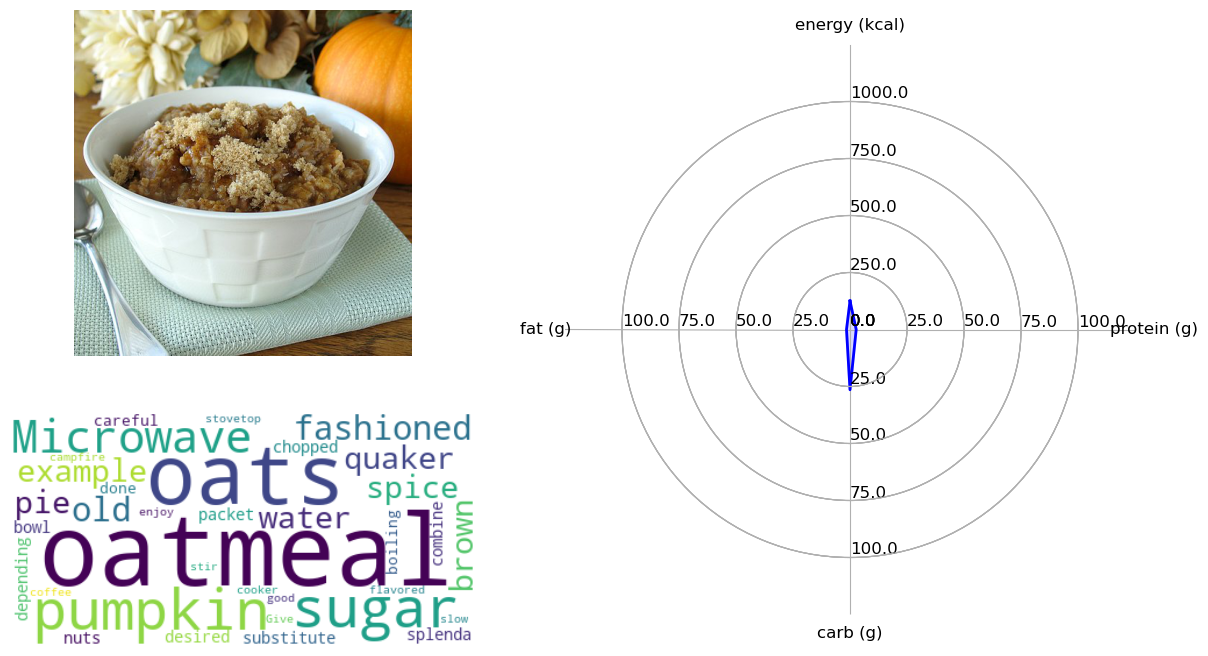

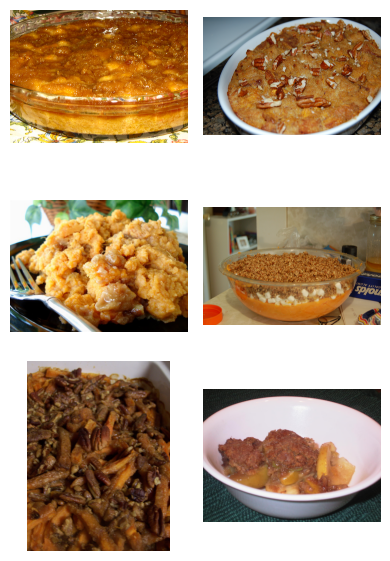

id: recipes-3_00008000


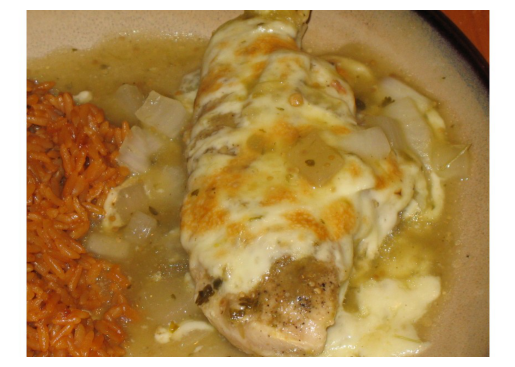

Title: Chicken Breasts with Tomatillo Salsa
Ingredients:
4  boneless skinless chicken breast halves
 garlic powder
 salt and pepper
1/4 teaspoon    cumin seed
1/2 medium    onion, halved and sliced
1 (1   pint) jar   tomatillo salsa (mild or hot)
4  slices    monterey jack pepper cheese
1/4 cup   loosely packed chopped cilantro
4  tablespoons    sour cream
8  flour tortillas
Instructions:
1. Line baking tray with aluminum foil.
2. Place chicken breasts on foil.
3. Sprinkle with garlic powder, salt, and pepper to taste.
4. Sprinkle with cumin seed.
5. Place 1/4 of onion slices on each chicken breast half.
6. Cover all with tomatillo salsa.
7. Place another sheet of aluminum foil on top of chicken breasts and fold all four sides until sealed very tight.
8. Bake foil packet on tray in 375 oven for 30 minutes.
9. Remove from oven and carefully remove top foil sheet.
10. Place a slice of pepper jack cheese on each chicken breast half.
11. Sprinkle all with chopped cilantro.
12. Return to th

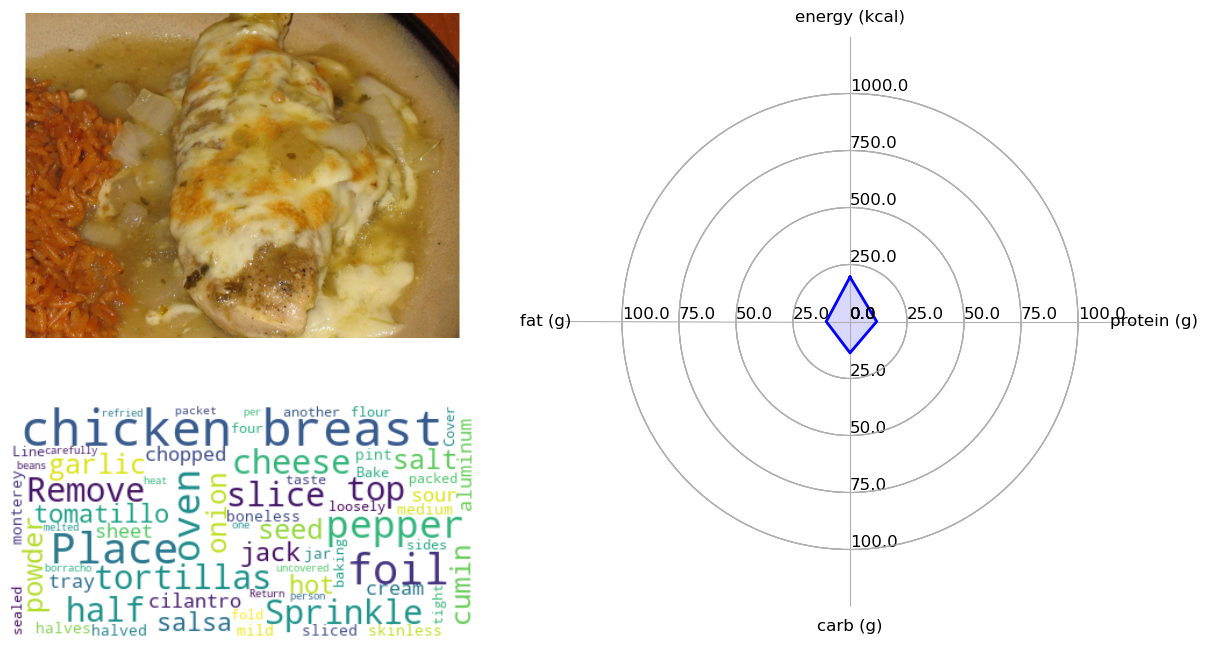

OSError: image file is truncated (1 bytes not processed)

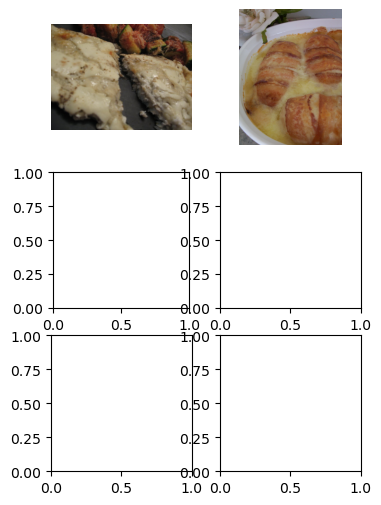

In [49]:
# mid mean_mases

for i in range(10):
    example = best_mean_mases[i+2030]
    print(f'id: {example}')
    plt.figure()
    img = get_img(example)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    show_recipe_result(example)
    fig = plt.figure(figsize=(4,6))
    axs = fig.subplots(3,2)
    for idx, retrieved in enumerate(im2recipe[example][:6]):
        img = get_img(retrieved)
        axs[idx//2,idx%2].imshow(img)
        axs[idx//2,idx%2].axis('off')
    plt.tight_layout()
    # plt.subplots_adjust(wspace=0)
    plt.show()

In [ ]:
# mid iou corr

for i in range(4):
    example = best_corrs_ious[i+4000]
    print(f'id: {example}')
    plt.figure()
    img = get_img(example)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    show_recipe_result(example)
    fig = plt.figure(figsize=(4,6))
    axs = fig.subplots(3,2)
    for idx, retrieved in enumerate(im2recipe[example][:6]):
        img = get_img(retrieved)
        axs[idx//2,idx%2].imshow(img)
        axs[idx//2,idx%2].axis('off')
    plt.tight_layout()
    # plt.subplots_adjust(wspace=0)
    plt.show()

In [ ]:
# mid iou mean

for i in range(4):
    example = best_mean_ious[i+4000]
    print(f'id: {example}')
    plt.figure()
    img = get_img(example)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    show_recipe_result(example)
    fig = plt.figure(figsize=(4,6))
    axs = fig.subplots(3,2)
    for idx, retrieved in enumerate(im2recipe[example][:6]):
        img = get_img(retrieved)
        axs[idx//2,idx%2].imshow(img)
        axs[idx//2,idx%2].axis('off')
    plt.tight_layout()
    # plt.subplots_adjust(wspace=0)
    plt.show()